# Case Study: Edge Detection

In [1]:
import requests
jpeg = requests.get('https://upload.wikimedia.org/wikipedia/commons/d/d8/NASA_Mars_Rover.jpg').content

In [2]:
import numpy as np
from io import BytesIO

from PIL import Image
import matplotlib.pyplot as plt
%config InlineBackend.figure_format ='retina'

pixels_scaled = {
    p: np.array(Image.open(BytesIO(jpeg)).resize([p, p], Image.BICUBIC)).astype(float) / 255
    for p in [100, 300, 600, 1000]
}

plt.figure(figsize=[10, 10])
plt.imshow(pixels_scaled[1000])
plt.xticks([])
plt.yticks([])
plt.show()

<Figure size 1000x1000 with 1 Axes>

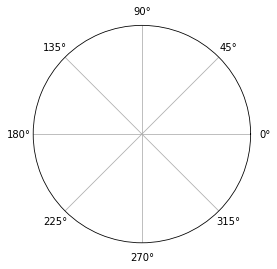

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=[4, 4])
plt.polar()
plt.yticks([])
plt.show()

In [4]:
import tensorflow as tf

# Convolution via Tensorflow for a single multi-channel image,
# and a four-dimensional filter (h, w, in, out). Paddin is same,
# while strides are 1. Additionally, sigmoid activation is applied.
def conv2d(image: np.array, kernel: np.array):
    
    # Desired input shape = batch, height, width, channel
    # so we need to add 0th axis.
    image_batch = np.expand_dims(image, 0)
    image_tensor = tf.constant(image_batch)

    # Filter weights
    filter_tensor = tf.constant(kernel, dtype=tf.float64)

    # Convolution operation
    conv_tensor = tf.nn.conv2d(
        image_tensor, 
        filter_tensor,
        strides=[1, 1, 1, 1],
        padding="SAME"
    )
    
    # In order to visualize activations, we need
    # to bound the values in [0, 1] range.
    activation_tensor = tf.math.sigmoid(conv_tensor)

    with tf.Session() as s:
        return s.run(activation_tensor)[0]

In [5]:
# Define 4 different 3x3 filters
filters = {
    '0 degrees': [
        [-1, -1, -1],
        [ 0,  0,  0],
        [ 1,  1,  1]
    ],
    
    '90 degrees': [
        [-1, 0, 1],
        [-1, 0, 1],
        [-1, 0, 1]
    ],

    '45 degrees': [
        [-1, -1,  0],
        [-1,  0,  1],
        [ 0,  1,  1]
    ],
    
    '135 degrees': [
        [ 0,  1, 1],
        [-1,  0, 1],
        [-1, -1, 0]
    ]
}

filters['180 degrees'] = -1 * np.array(filters['0 degrees'])
filters['225 degrees'] = -1 * np.array(filters['45 degrees'])
filters['270 degrees'] = -1 * np.array(filters['90 degrees'])

filter_names = list(filters.keys())

# Duplicate the filters across every image channel
filters = np.array([
    np.repeat(np.array(f), 3).reshape(3, 3, 3)
    for n, f in filters.items()
])

# Currently, the output channel is the 1st dimension
# However, Tensorflow requires the output channel to be 4th
filters = np.moveaxis(filters, 0, 3)

input_image = pixels_scaled[300]
activation = conv2d(input_image, filters)

In [6]:
{
    'input_shape': input_image.shape,
    'filter_shape': filters.shape,
    'output_shape': activation.shape
}

{'input_shape': (300, 300, 3),
 'filter_shape': (3, 3, 3, 7),
 'output_shape': (300, 300, 7)}

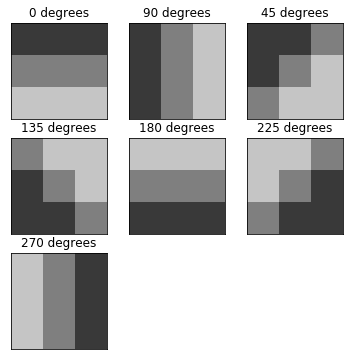

In [7]:
from utils import plot_conv_kernel
    
plot_conv_kernel(filters, labels=filter_names)

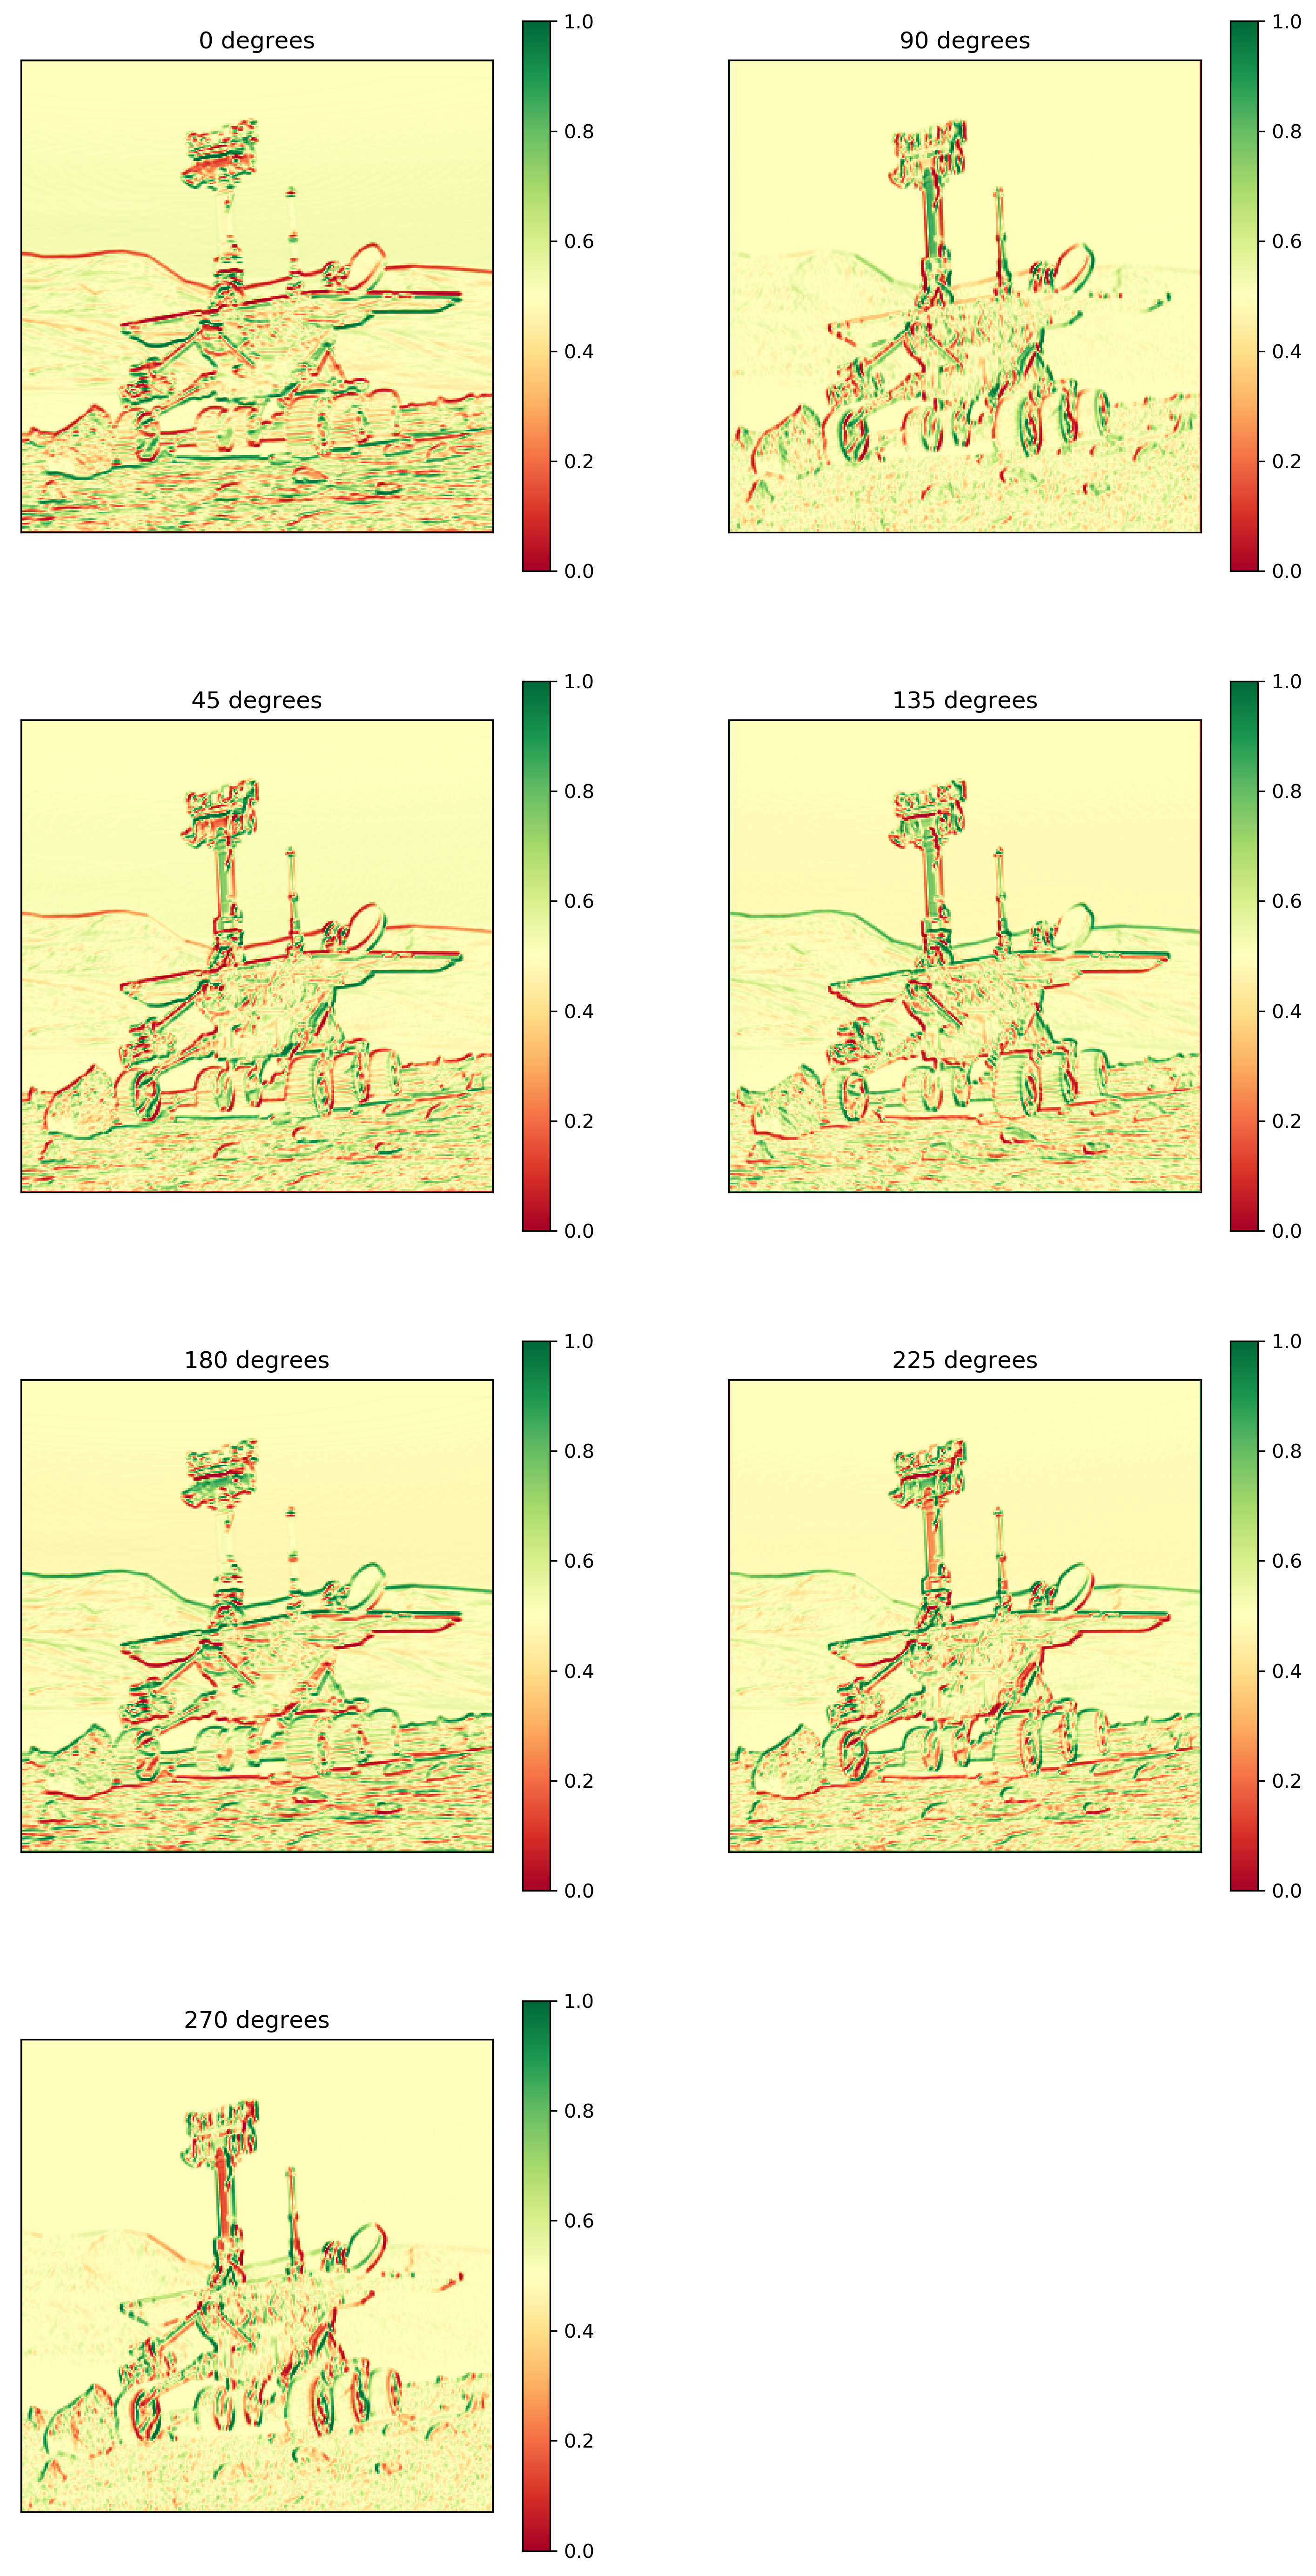

In [8]:
import matplotlib.pyplot as plt
import math

cols = 2
rows = math.ceil(len(filter_names) / cols)
fig = plt.figure(figsize=[6 * cols, 6 * rows], dpi=300)

for idx, name in enumerate(filter_names):
    ax = plt.subplot(rows, cols, idx+1)
    plt.title(name)
    plt.yticks([])
    plt.xticks([])
    pos = plt.imshow(
        activation[:, :, idx], 
        cmap=plt.get_cmap('RdYlGn'), 
        vmin=0, 
        vmax=1
    )
    cb = fig.colorbar(pos, ax=ax)

In [9]:
def max_pool(image, surface_size, depth_size):
    image_batch = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])
    image_tensor = tf.constant(image_batch)

    max_pool_tensor = tf.nn.max_pool(
        image_tensor,
        [1, surface_size, surface_size, depth_size],
        [1, 1, 1, depth_size],
        'VALID'
    )

    with tf.Session() as s:
        return s.run(max_pool_tensor)[0]
    
input_channels = activation.shape[2]
activations_by_window = {
    (surface_size, depth_size): max_pool(activation[:, :, :], surface_size, depth_size)
    for surface_size, depth_size in [(1, input_channels), (5, 1), (10, 1), (30, 1)]
}

{w: a.shape for w, a in activations_by_window.items()}

{(1, 7): (300, 300, 1),
 (5, 1): (296, 296, 7),
 (10, 1): (291, 291, 7),
 (30, 1): (271, 271, 7)}

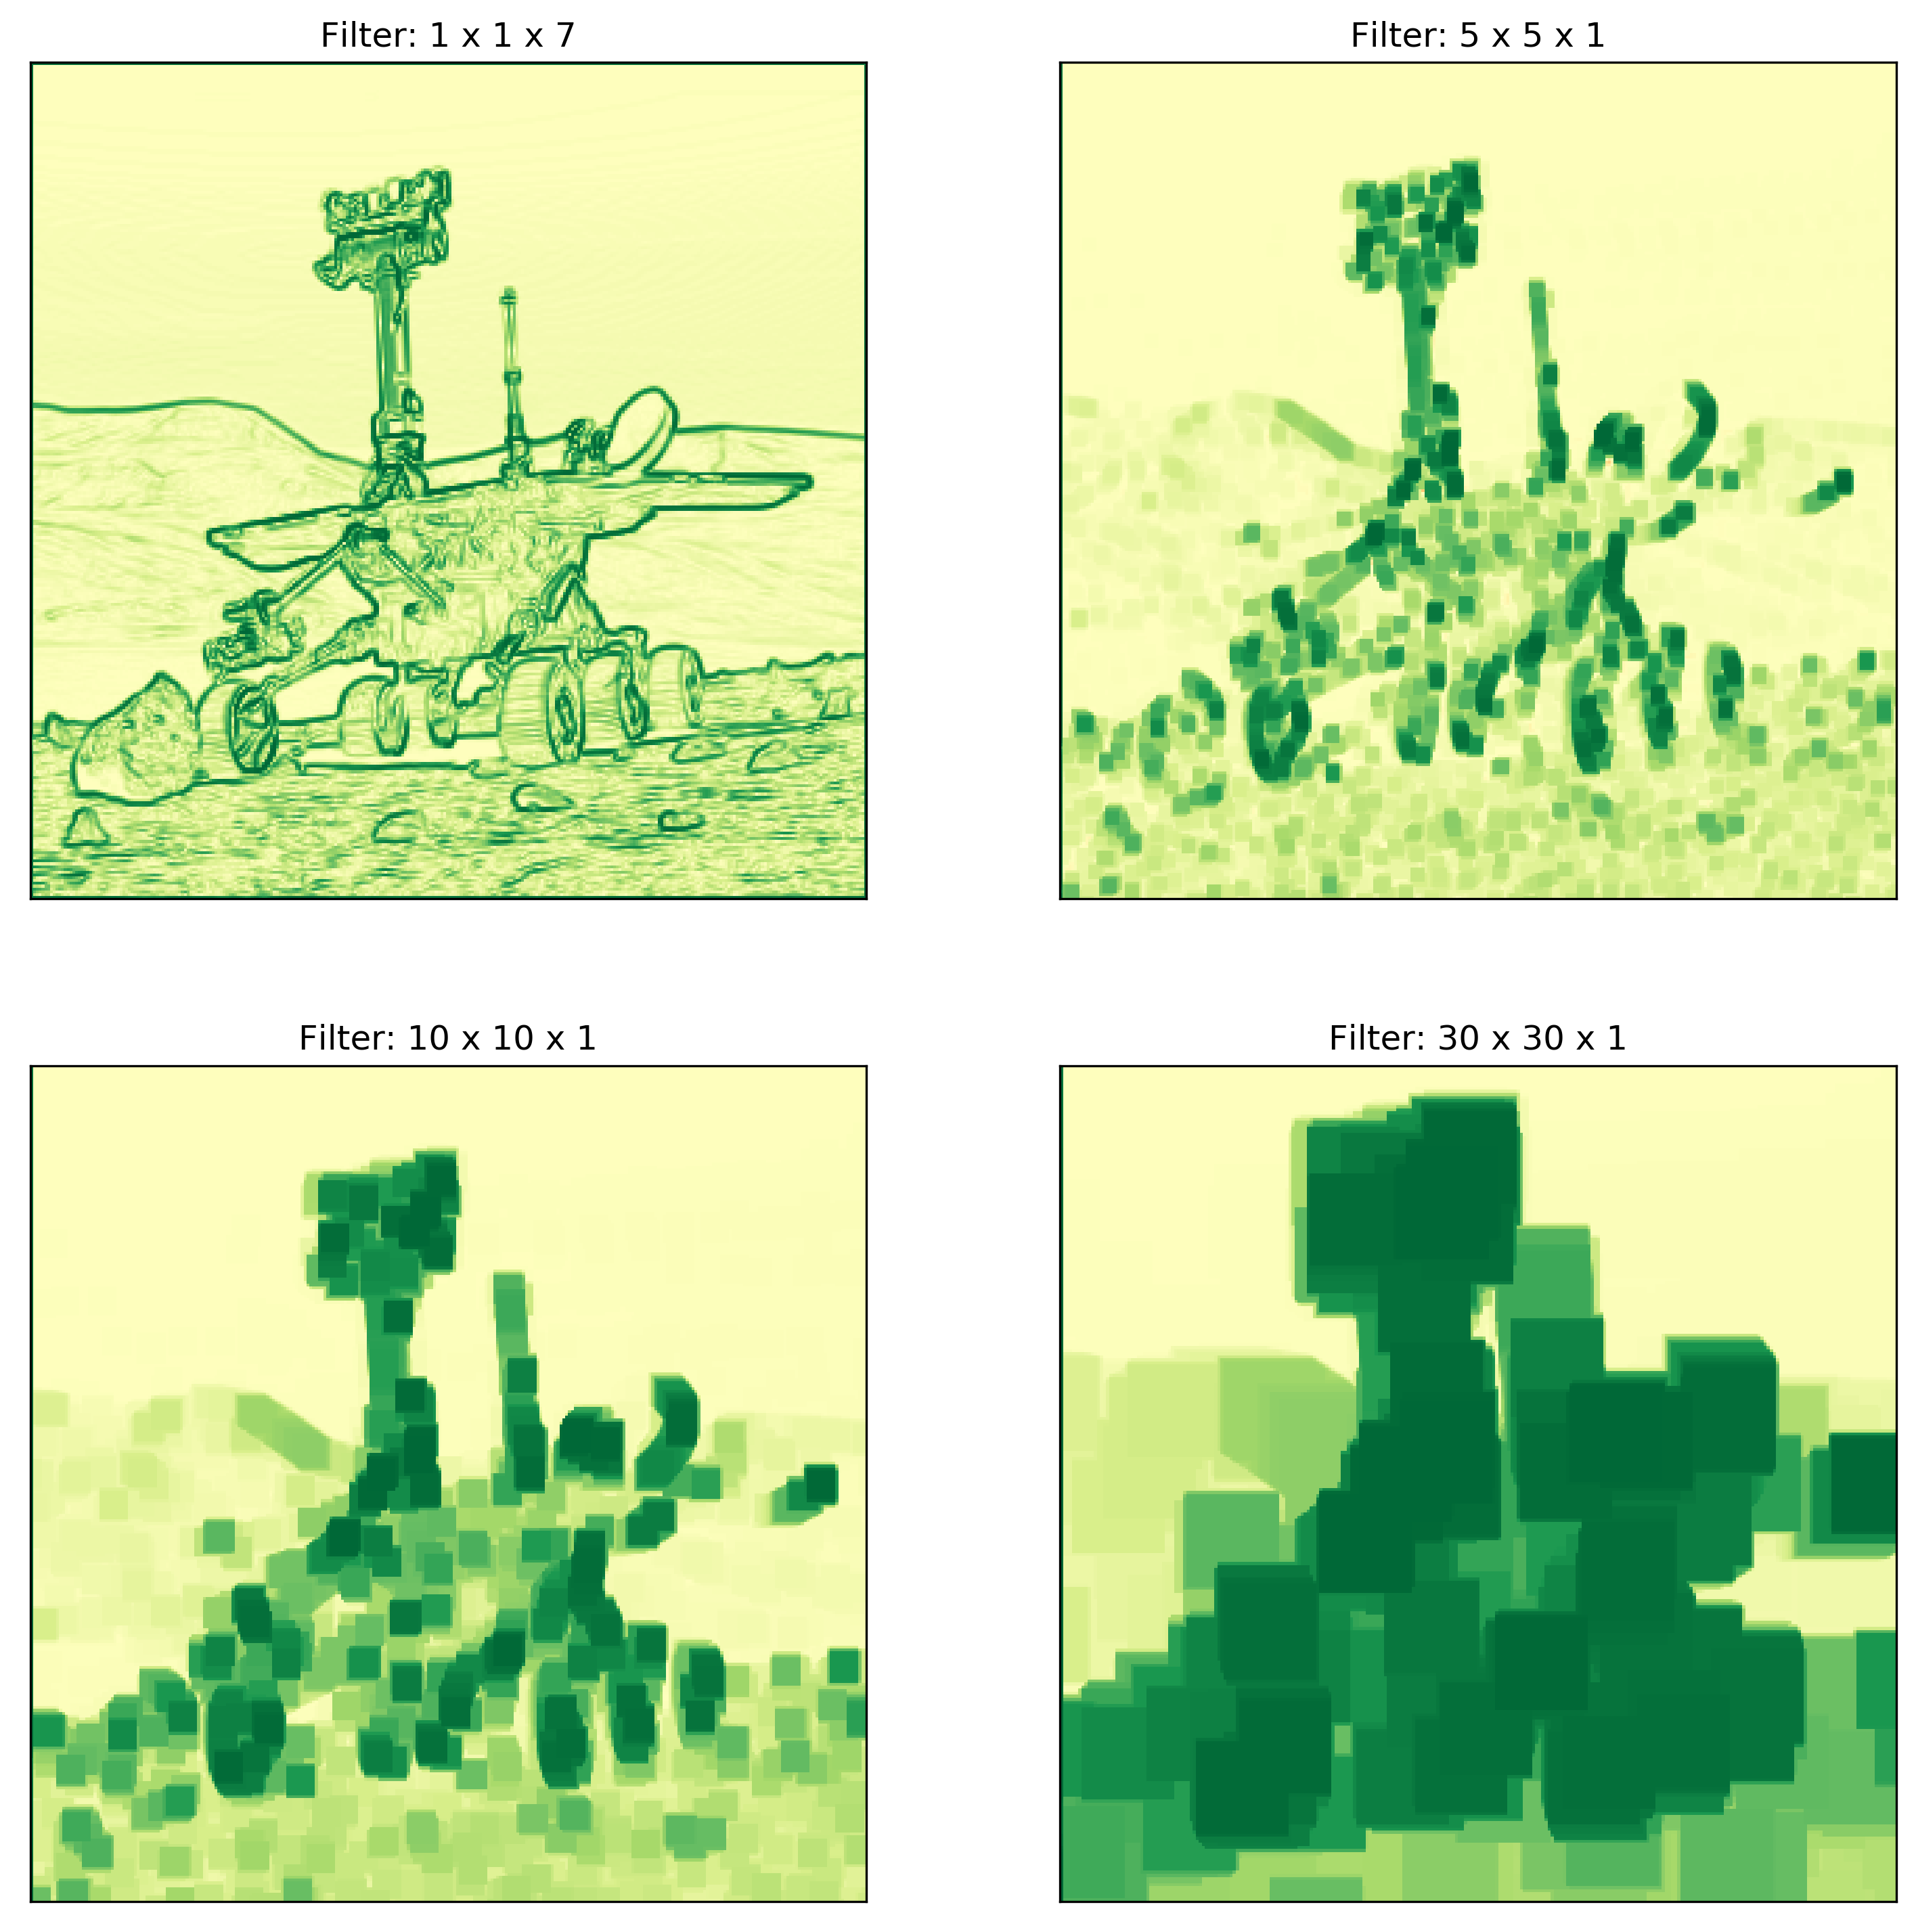

In [10]:
cols = 2
rows = math.ceil(len(activations_by_window.keys()) / cols)

plt.figure(figsize=[6 * cols, 6 * rows], dpi=300)

for idx, ((surface_size, depth_size), image) in enumerate(activations_by_window.items()):
    plt.subplot(rows, cols, idx+1)
    plt.title(f'Filter: {surface_size} x {surface_size} x {depth_size}')
    plt.xticks([])
    plt.yticks([])
    plt.imshow(
        image[:, :, 1 if image.shape[2] > 1 else 0], 
        cmap=plt.get_cmap('RdYlGn'), 
        vmin=0, 
        vmax=1
    )